# RAG Experiments

Today we will be extending the work we did last week with RAG. Last week we went over the RAG pipeline at a high level and computed embeddings while prototyping the retrieval half of RAG.

This time, we will extend our document set from 20k documents to 100k documents, as well as hook up the second half of the generator LLM.

There are a lot of hyper parameters and experiments we will be walking through, so please feel free to chime in the chat if at any point you are wondering what is going on under the hood!

## Tools

* [Oxen.ai](https://oxen.ai) for raw data storage and data debugging
* [Chroma](https://www.trychroma.com/) for vector db / embedding search
* [Hugging Face](https://huggingface.co) transformers library

## Models

* GTE Embeddings (https://huggingface.co/thenlper/gte-large)
* Mistral-7B (https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)
* Llama 7B (https://huggingface.co/meta-llama/Llama-2-7b-chat-hf)
* OpenAI GPT-3.5 (https://platform.openai.com/docs/models/gpt-3-5)

# Install Dependencies

In [ ]:
!pip install oxenai
!pip install matplotlib

# Download Data From Oxen.ai

The raw text data and embeddings for this experiment is hosted on Oxen.ai and was computed in part 1 of this dive

In [132]:
import oxen
from oxen import RemoteRepo

# Oxen allows you to download individual files or directories from a version, so you don't need the entire 6GB repository
repo = RemoteRepo("ox/SQuAD-Context")
repo.download("data/dev/embeddings.parquet")
repo.download("data/dev/contexts.jsonl")
repo.download("data/dev/questions.jsonl")


In [133]:
!tree data

data
└── dev
    ├── contexts.jsonl
    ├── embeddings.parquet
    └── questions.jsonl

1 directory, 3 files


In [134]:
!oxen df data/dev/embeddings.parquet

shape: (1_203, 3)
┌──────────────────────────┬─────────────────────────┬─────────────────────────┐
│ context                  ┆ question_ids            ┆ embedding               │
│ ---                      ┆ ---                     ┆ ---                     │
│ str                      ┆ list[str]               ┆ list[f64]               │
╞══════════════════════════╪═════════════════════════╪═════════════════════════╡
│ The Normans (Norman:     ┆ ["56ddde6b9a695914005b9 ┆ [-0.081646, 0.181421, … │
│ Nourmands; …             ┆ 628", "56…              ┆ -0.16844…               │
│ The Norman dynasty had a ┆ ["56dddf4066d3e219004da ┆ [-0.042472, 0.124636, … │
│ major p…                 ┆ d5f", "56…              ┆ -0.27204…               │
│ The English name         ┆ ["56dde0379a695914005b9 ┆ [-0.033812, -0.090035,  │
│ "Normans" comes…         ┆ 636", "56…              ┆ … -0.1916…              │
│ In the course of the     ┆ ["56dde0ba66d3e219004da ┆ [-0.189234, 0.325601, … │
│ 10th cen

In [135]:
!ls data/dev

contexts.jsonl	embeddings.parquet  questions.jsonl


# Index Embeddings

Run the script to insert the embeddings into ChromaDB

In [137]:
!python index_into_chroma.py -i data/dev/embeddings.parquet -o chroma-dev.db

Creating collection squad_embeddings...
Reading embeddings file data/dev/embeddings.parquet...
                                             context  ...                                          embedding
0  The Normans (Norman: Nourmands; French: Norman...  ...  [-0.08164554089307785, 0.1814206838607788, -0....
1  The Norman dynasty had a major political, cult...  ...  [-0.042471904307603836, 0.12463627755641937, -...
2  The English name "Normans" comes from the Fren...  ...  [-0.03381205350160599, -0.09003488719463348, 0...
3  In the course of the 10th century, the initial...  ...  [-0.18923383951187134, 0.3256005644798279, 0.3...
4  Before Rollo's arrival, its populations did no...  ...  [-0.04087124764919281, 0.04648030176758766, 0....

[5 rows x 3 columns]
Indexing into ChromaDB...
1203it [00:04, 286.88it/s]
Indexed 1203 rows in 4.20 seconds


Note: It is relatively fast to index under 100k embeddings. When I got up to 300k things started to slow down significantly, and we are still not to indexing 1 million after running over night.

The embeddings are already computed, we just are purely indexing into Chroma.

Maybe there are vector databases build for larger scale than Chroma? 

Curious if anyone else has tried any other of them?

# Calculating Recall

Recall in the context of Question Answering with evidence can be thought of as "how often did we find the answer in the sea of our documents."

## 🔎 Search is half the battle

Let's generate a data frame of results to see how well our model can find the correct answer in our embeddings database. 

[Recall@10 for 1k Documents](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-recall-10-1k-docs.jsonl)

I took the luxury of running this code before hand so that we don't have to wait for all 1000 searches to finish.

```bash
mkdir experiments

python compute_recall.py -n 10 -i data/dev/questions.jsonl -d chroma-dev.db/ -o experimentsdev-recall-10-1k-docs.jsonl --filter "not_in_context"
```

Once you have computed an output file, you may want to upload it to Oxen.ai to vet the results.

```
oxen add dev-recall-10-1k-docs.jsonl
oxen commit -m "adding recall data"
oxen push
```

https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-recall-10-1k-docs.jsonl

You'll see why this is important later. For now, let's look at some results.


In [6]:
import pandas as pd

def compute_recall(filepath):
    df = pd.read_json(filepath, lines=True)
    found_answers = df['found_answer'].value_counts()
    num_found = found_answers[0]
    total = df.shape[0]
    recall = num_found / total * 100.0
    print(f"Recall = {num_found} / {total} = {recall}")
    return df, recall

In [44]:
def plot_recall(df):
    height = df.shape[0]
    df = df[df['found_idx'] != -1] # filter out ones we didn't find
    result_counts = df['found_idx'].value_counts()
    results = result_counts.sort_index().cumsum() / height
    print(results)
    plot = results.plot(xlabel="Number of Documents (N)", ylabel="Recall @ N", kind="line")
    
    return plot.set_ylim(bottom=0, top=1.0)
    

In [25]:
!ls -trl SQuAD-Context/experiments/

total 65296
-rw-rw-r-- 1 ubuntu ubuntu   286672 Jan  9 19:37 dev-mistral-recall-3-precision-0-shot.jsonl
-rw-rw-r-- 1 ubuntu ubuntu   279177 Jan  9 19:45 dev-llama-recall-3-precision-3-shot.jsonl
-rw-rw-r-- 1 ubuntu ubuntu   284929 Jan  9 19:51 dev-mistral-recall-3-precision-3-shot.jsonl
-rw-rw-r-- 1 ubuntu ubuntu  8470010 Jan  9 23:22 dev-recall-10-1k-docs.jsonl
-rw-rw-r-- 1 ubuntu ubuntu  6689448 Jan  9 23:36 dev-recall-10-11k-docs.jsonl
-rw-rw-r-- 1 ubuntu ubuntu 40556470 Jan 10 02:31 dev-recall-100-101k-docs.jsonl
-rw-rw-r-- 1 ubuntu ubuntu  5801655 Jan 10 02:44 dev-recall-10-101k-docs.jsonl
-rw-rw-r-- 1 ubuntu ubuntu  4479370 Jan 10 07:18 dev-recall-10-10k-docs.jsonl


# Recall@10 for 1k Documents

In [42]:
df, recall = compute_recall("SQuAD-Context/experiments/dev-recall-10-1k-docs.jsonl")


Recall = 914 / 1000 = 91.4


# It's relatively easy to find our document in a set of 1000

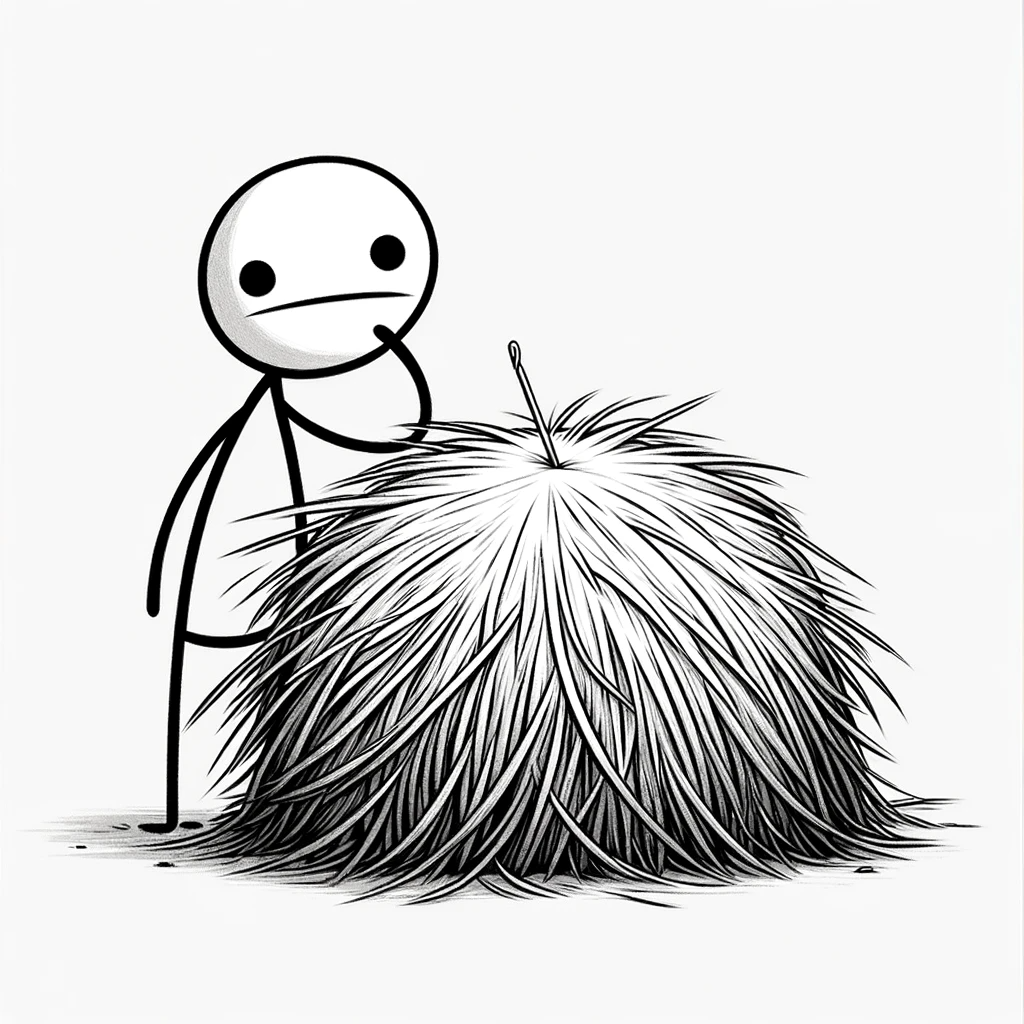

In [125]:
from PIL import Image
from IPython.display import display

display(Image.open('images/stick_1.png'))

# The Answer was returned in the top 10 documents 91.4% of the time

found_idx
0    0.692
1    0.797
2    0.833
3    0.855
4    0.873
5    0.890
6    0.900
7    0.906
8    0.910
9    0.914
Name: count, dtype: float64


(0.0, 1.0)

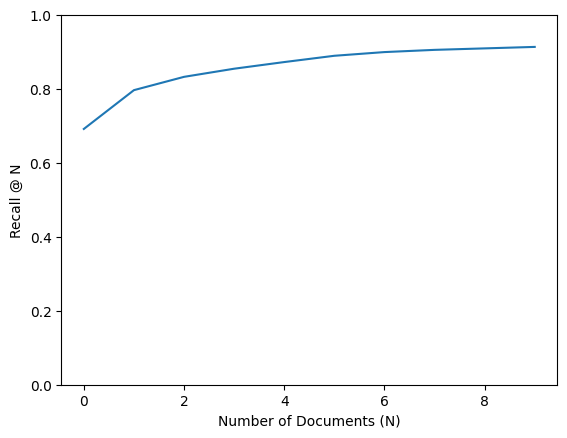

In [45]:
plot_recall(df)

# Add Moooo're Documents 🐂

It is relatively easy to find a needle in a haystack of 1,204 documents. What if we add random noise?

[data/noise/10k.parquet](https://www.oxen.ai/ox/SQuAD-Context/file/main/data/noise/10k.parquet)


In [ ]:
import oxen
from oxen import RemoteRepo

# Oxen allows you to download individual files or directories from a version, so you don't need the entire 6GB repository
repo = RemoteRepo("ox/SQuAD-Context")
repo.download("data/noise/10k.parquet")


```bash
python index_into_chroma.py -i data/noise/10k.parquet -o chroma-dev.db --append
````

We get worse results as we add more documents, as should be expected. It is harder to find a needle in a larger haystack. 

# Recall@10 for 10k Documents

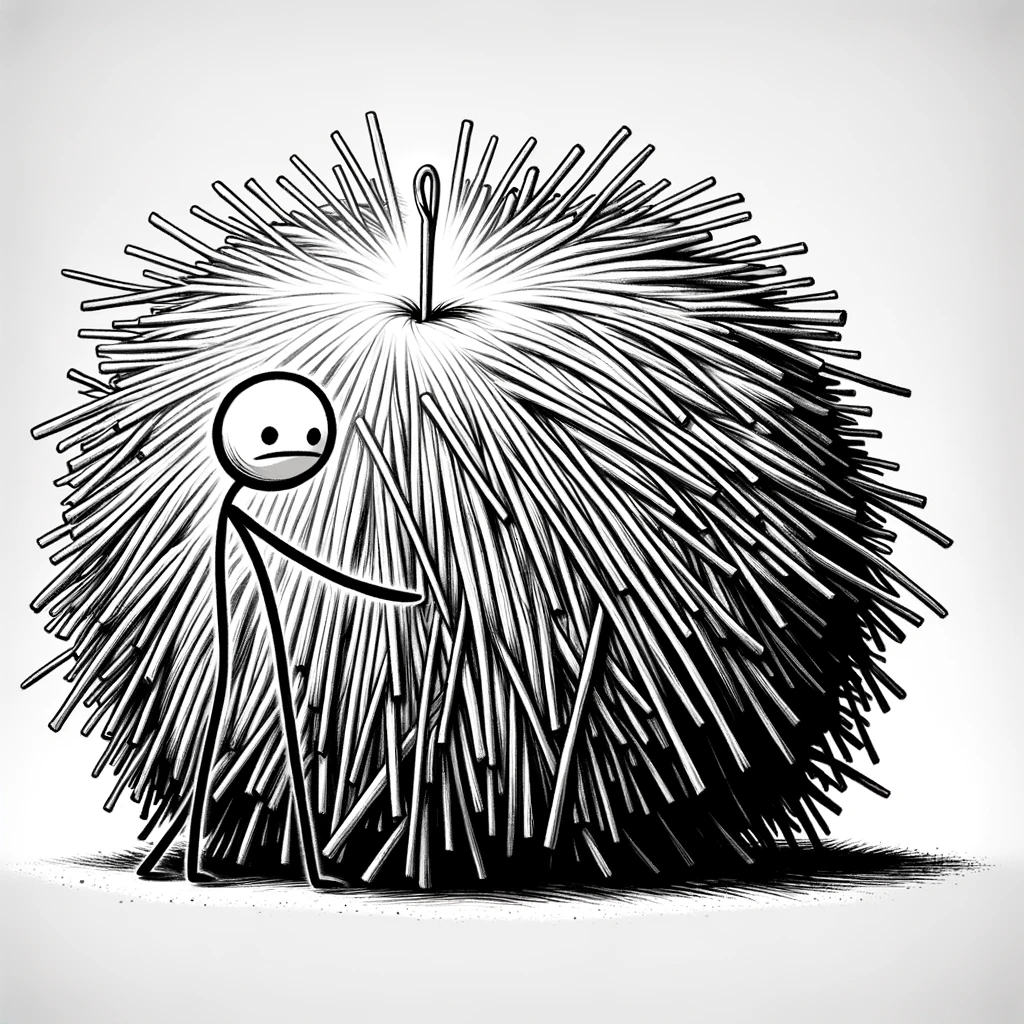

In [127]:
display(Image.open('images/stick_2.png'))

# Still in the top ten 83% of the time

To see where there results sets differ, we are working on a comparison feature.

https://www.oxen.ai/ox/SQuAD-Context/schemas/compare/1



In [48]:
df, recall = compute_recall("SQuAD-Context/experiments/dev-recall-10-10k-docs.jsonl")

Recall = 835 / 1000 = 83.5


found_idx
0    0.625
1    0.721
2    0.757
3    0.778
4    0.795
5    0.807
6    0.821
7    0.825
8    0.826
9    0.835
Name: count, dtype: float64


(0.0, 1.0)

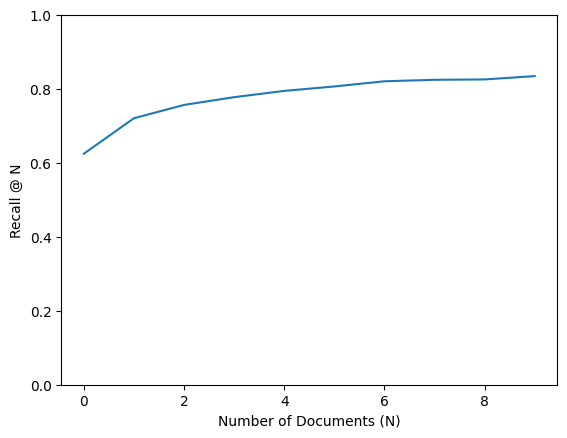

In [49]:
plot_recall(df)

# Recall@10 for 101k Documents

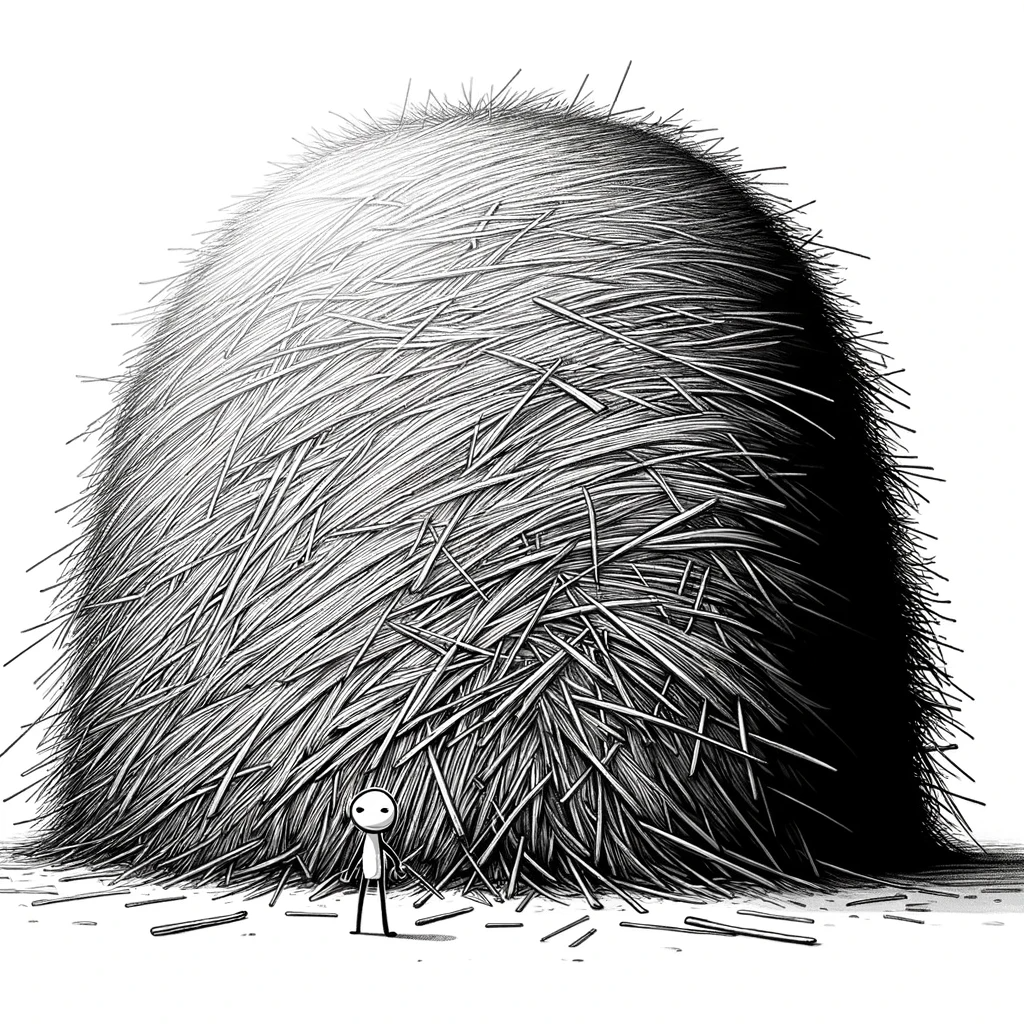

In [126]:
display(Image.open('images/stick_3.png'))

# Down to 52% Recall@10 with 100k documents

The first time I ran this experiment, the recall was extremely low, and I thought we might be out of luck with this embedding model.


In [78]:
import oxen

repo = oxen.RemoteRepo("ox/SQuAD-Context")
# Grab the version from an earlier revision
repo.download("experiments/dev-recall-10-101k-docs.jsonl", revision="549b990322f24d5b")

In [79]:
!ls experiments

dev-recall-10-101k-docs.jsonl


In [80]:
df, recall = compute_recall("experiments/dev-recall-10-101k-docs.jsonl")

Recall = 526 / 1000 = 52.6


found_idx
0    0.386
1    0.453
2    0.477
3    0.489
4    0.496
5    0.505
6    0.511
7    0.517
8    0.522
9    0.526
Name: count, dtype: float64


(0.0, 1.0)

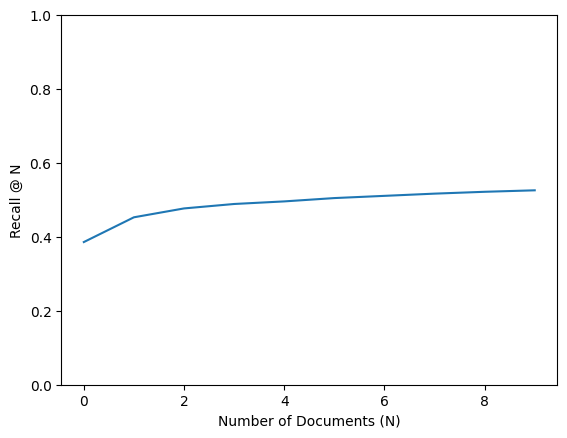

In [81]:
plot_recall(df)

# 🔎 Double Check Your Work

Looking closer, this was user error. Some documents were simply empty, and they were the nearest neighbors for some reason, meaning our RAG result set was empty. 

https://www.oxen.ai/ox/SQuAD-Context/file/549b990322f24d5b/experiments/dev-recall-10-101k-docs.jsonl

Moral of story, make sure your documents are clean, and look at your results and don't just trust the numbers. After cleaning out the empty strings, I ran the process again.


In [85]:
import oxen

repo = oxen.RemoteRepo("ox/SQuAD-Context")
# Grab the latest version
repo.download("experiments/dev-recall-10-101k-docs.jsonl")


In [86]:
df, recall = compute_recall("experiments/dev-recall-10-101k-docs.jsonl")

Recall = 746 / 1000 = 74.6


found_idx
0    0.552
1    0.650
2    0.681
3    0.695
4    0.706
5    0.717
6    0.729
7    0.737
8    0.742
9    0.746
Name: count, dtype: float64


(0.0, 1.0)

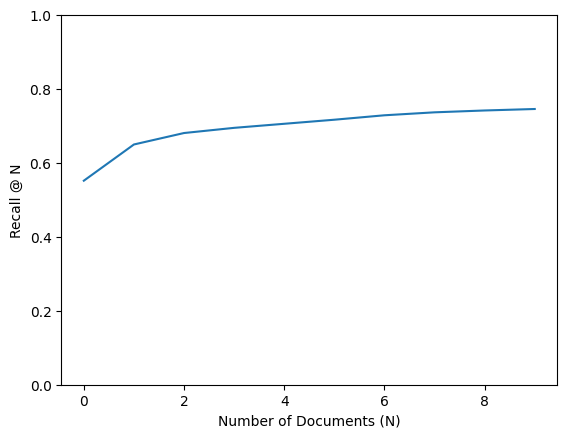

In [87]:
plot_recall(df)

# What if we return 100 Documents?

In [10]:
df, recall = compute_recall("SQuAD-Context/experiments/dev-recall-100-101k-docs.jsonl")

Recall = 927 / 1000 = 92.7


found_idx
0     62.1
1     73.1
2     76.5
3     78.1
4     79.4
5     80.4
6     81.6
7     82.7
8     83.3
9     83.8
10    84.1
11    84.4
12    85.2
13    85.4
14    85.7
15    86.7
16    87.5
17    87.9
18    88.6
19    89.0
21    89.2
22    89.6
23    89.7
26    89.8
27    90.0
28    90.1
29    90.2
30    90.3
32    90.5
36    90.6
39    90.7
41    90.8
42    91.0
44    91.1
45    91.2
47    91.3
50    91.4
57    91.7
58    91.8
59    91.9
60    92.0
62    92.1
64    92.2
75    92.3
77    92.4
80    92.5
89    92.6
98    92.7
Name: count, dtype: float64


(0.0, 100.0)

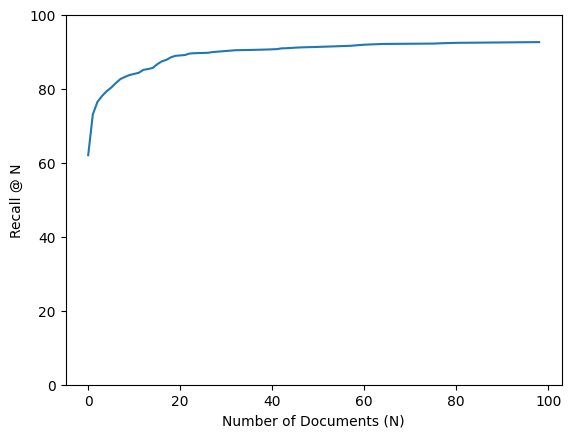

In [11]:
plot_recall(df)

# Computing Precision

Assuming we can find answers with 92% Recall, now it's all about extracting the right answer. We have a script to compute precision given a model and a precomputed results set.

[compute_precision.py](https://github.com/Oxen-AI/rag-dive/blob/main/compute_precision.py)

Let's start with OpenAI gpt-3.5 as our baseline. If we can get an open source model that is competitive that's great, but this is probably the cheapest and most reliable option to date.

```bash
python compute_precision.py -m gpt-3.5-turbo -d SQuAD-Context/experiments/dev-recall-100-101k-docs.jsonl -o SQuAD-Context/experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl -n 3 -s openai -l 5
```


In [145]:
import oxen
import pandas

repo = oxen.RemoteRepo("ox/SQuAD-Context")
# Grab the latest version
repo.download("experiments/dev-gpt-3.5-turbo-recall-1-precision-0-shot.jsonl")
repo.download("experiments/dev-gpt-3.5-turbo-recall-3-precision-3-shot.jsonl")
repo.download("experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl")
repo.download("experiments/dev-mistral-7b-instruct-v0.2-recall-1-precision-0-shot.jsonl")
repo.download("experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl")
repo.download("experiments/dev-mistral-7b-instruct-v0.2-turbo-recall-3-precision-3-shot.jsonl")
repo.download("experiments/dev-gpt-3.5-turbo-recall-1-precision-0-shot.jsonl")
repo.download("experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl")
repo.download("experiments/dev-mistral-7b-instruct-v0.2-recall-1-precision-0-shot.jsonl")

df = pd.read_json("experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl", lines=True)
df

,idx,question_id,question,context,answer,guess,search_found_answer,is_correct,time
0,0,57269e3bf1498d1400e8e518,How long did Ms Kucukdeveci work for Swedex Gm...,Her employment experience has been with the Ug...,10 years,not_in_context,False,False,0.562893
1,1,571090abb654c5140001f996,What house was the site of a weaving school in...,Other evidence of the Walloons and Huguenots i...,The Weavers,The Weavers,True,True,0.499355
2,2,5706149552bb891400689880,Which team was suspended from the MLS?,"From 2005 to 2014, there were two Major League...",Chivas USA,Chivas,True,True,0.444808
3,3,571090abb654c5140001f998,What other English towns were sites of Hugueno...,Huguenot immigrants did not disperse or settle...,"Kent, particularly Sandwich, Faversham and Mai...","Cork, Portarlington, Lisburn, Waterford, and Y...",False,False,0.428961
4,4,57379ed81c456719005744d8,What is the final effect of adding more and mo...,"In fact, I bet you'll start repeating known co...",conservation of mechanical energy,not_in_context,False,False,0.470917
...,...,...,...,...,...,...,...,...,...
995,995,5733eb34d058e614000b65cc,What was William Johnson's role in British mil...,The Iroquois sent runners to the manor of Will...,British Superintendent for Indian Affairs in t...,Colonel,True,False,0.459417
996,996,57265d08708984140094c39b,In what decade was seafloor spreading discover...,"In the 1960s, a series of discoveries, the mos...",the 1960s,1960s,True,True,0.488356
997,997,57300911947a6a140053cfb6,When did Germanic tribes cross the Rhine to mi...,Germanic tribes crossed the Rhine in the Migra...,5th century,5th century,True,True,0.258349
998,998,57094ca7efce8f15003a7dd7,When did Sky launch a TV advertising campaign ...,The Daily Mail newspaper reported in 2012 that...,September 2007,not_in_context,False,False,0.493766


,idx,question_id,question,context,answer,guess,search_found_answer,is_correct,time
0,0,57269e3bf1498d1400e8e518,How long did Ms Kucukdeveci work for Swedex Gm...,Her employment experience has been with the Ug...,10 years,not_in_context,False,False,0.562893
1,1,571090abb654c5140001f996,What house was the site of a weaving school in...,Other evidence of the Walloons and Huguenots i...,The Weavers,The Weavers,True,True,0.499355
2,2,5706149552bb891400689880,Which team was suspended from the MLS?,"From 2005 to 2014, there were two Major League...",Chivas USA,Chivas,True,True,0.444808
3,3,571090abb654c5140001f998,What other English towns were sites of Hugueno...,Huguenot immigrants did not disperse or settle...,"Kent, particularly Sandwich, Faversham and Mai...","Cork, Portarlington, Lisburn, Waterford, and Y...",False,False,0.428961
4,4,57379ed81c456719005744d8,What is the final effect of adding more and mo...,"In fact, I bet you'll start repeating known co...",conservation of mechanical energy,not_in_context,False,False,0.470917
...,...,...,...,...,...,...,...,...,...
995,995,5733eb34d058e614000b65cc,What was William Johnson's role in British mil...,The Iroquois sent runners to the manor of Will...,British Superintendent for Indian Affairs in t...,Colonel,True,False,0.459417
996,996,57265d08708984140094c39b,In what decade was seafloor spreading discover...,"In the 1960s, a series of discoveries, the mos...",the 1960s,1960s,True,True,0.488356
997,997,57300911947a6a140053cfb6,When did Germanic tribes cross the Rhine to mi...,Germanic tribes crossed the Rhine in the Migra...,5th century,5th century,True,True,0.258349
998,998,57094ca7efce8f15003a7dd7,When did Sky launch a TV advertising campaign ...,The Daily Mail newspaper reported in 2012 that...,September 2007,not_in_context,False,False,0.493766


In [123]:
import pandas as pd

def compute_precision(filepath):
    df = pd.read_json(filepath, lines=True)
    # only consider questions where the search found the answer
    df = df[df['search_found_answer']]
    correct_answers = df['is_correct'].value_counts()
    num_found = correct_answers[0]
    total = df.shape[0]
    precision = num_found / total * 100.0
    print(f"Precision = {num_found} / {total} = {precision}")
    return df, recall
    import oxen


# 🤝 Share your Results

I would love if instead of sharing a black box of accuracy numbers, people actually shared their results set, so we can see the strengths and weaknesses of these models with our own eyes.

This allows less technical team members to qualitatively see results, which can lead to quantitative improvements.

# OpenAI/gpt-3.5-turbo Precision @ Recall 1 + 3-shot = 81.1%

Look at the results 👇

[Recall 1 - 3 shot prompt gpt-3.5-turbo](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-gpt-3.5-turbo-recall-1-precision-3-shot.jsonl)


In [151]:
df, precision = compute_precision("experiments/dev-gpt-3.5-turbo-recall-1-precision-0-shot.jsonl")

Precision = 508 / 621 = 81.80354267310788


# OpenAI/gpt-3.5-turbo Precision @ Recall 1 + 0-shot = 81.8%

Look at the results 👇

[Recall 1 + 3 shot prompt gpt-3.5-turbo](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-gpt-3.5-turbo-recall-1-precision-0-shot.jsonl)


In [141]:
df, precision = compute_precision("experiments/dev-gpt-3.5-turbo-recall-1-precision-0-shot.jsonl")

Precision = 508 / 621 = 81.80354267310788


# OpenAI/gpt-3.5-turbo Precision @ Recall 3 = 76%

Look at the results 👇

[Recall 3 + 0-shot gpt-3.5-turbo](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-gpt-3.5-turbo-recall-3-precision-3-shot.jsonl)


In [131]:
df, precision = compute_precision("experiments/dev-gpt-3.5-turbo-recall-3-precision-3-shot.jsonl")

Precision = 583 / 765 = 76.20915032679738


# OpenAI/gpt-3.5-turbo Precision @ Recall 5 = 73%

Let's look at the results 👇

[Recall 5 gpt-3.5-turbo](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl)


In [129]:
df, precision = compute_precision("experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl")

Precision = 584 / 794 = 73.55163727959699


# Running Open Source Models

```
python compute_precision.py -m mistralai/Mistral-7B-Instruct-v0.2 -d SQuAD-Context/experiments/dev-recall-100-101k-docs.jsonl -o SQuAD-Context/experiments/dev-mistral-7b-instruct-v0.2-turbo-recall-3-precision-3-shot.jsonl -n 3 -s hugging_face -l 3
```

# Mistral-7B-Instruct-v0.2  Precision @ Recall 1 = 6264%

Let's look at the results 👇

[Mistral 7B Instruct v0.2](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-mistral-7b-instruct-v0.2-turbo-recall-3-precision-3-shot.jsonl)


In [148]:
df, precision = compute_precision("experiments/dev-mistral-7b-instruct-v0.2-recall-1-precision-0-shot.jsonl")

Precision = 391 / 621 = 62.96296296296296


# meta-llama/Llama-2-7b-chat-hf  Precision @ Recall 1 = 66%

Let's look at the results 👇

[meta-llama/Llama-2-7b-chat-hf](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl)


In [154]:
df, precision = compute_precision("experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl")

Precision = 412 / 621 = 66.34460547504025


In [139]:
df, precision = compute_precision("experiments/dev-mistral-7b-instruct-v0.2-turbo-recall-3-precision-3-shot.jsonl")

Precision = 490 / 765 = 64.05228758169935


# meta-llama/Llama-2-7b-chat-hf Precision @ Recall 1 + 0-shot = 66%

Let's look at the results 👇

[Recall 1 + 0-shot meta-llama/Llama-2-7b-chat-hf2](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl)


In [142]:
df, precision = compute_precision("experiments/dev-llama-7b-instruct-recall-1-precision-0-shot.jsonl")

Precision = 412 / 621 = 66.34460547504025


# Mistral-7B-Instruct-v0.2  Precision @ Recall 1 + 0-shot = 62%

Let's look at the results 👇

[Recall 1 + 0-shot Mistral-7B-Instruct-v0.2](https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-mistral-7b-instruct-v0.2-recall-1-precision-0-shot.jsonl)


In [146]:
df, precision = compute_precision("experiments/dev-mistral-7b-instruct-v0.2-recall-1-precision-0-shot.jsonl")

Precision = 391 / 621 = 62.96296296296296


# Context-Length

The biggest issue I had when evaluating *any* of these models was stuffing all of the recalled results into the context window of the model. 

When I tried to evaluate OpenAI/gpt-3.5-turbo, I got error messages from the API of context too long. When I tried to evaluate Mistral, I ran out of GPU memory. 

So I had to eval precision at a much lower Recall in order to make things work. Another option would be to individually analyze each returned document, rather than creating one giant context window, but that would be much more expensive.


# Plug and Play your Results

Now that we understand that RAG is essentially two halves we can separately optimize, plug and play your own models and data. One half of your team could be working on retrieval while the other is working on inference and generation. 

It takes a decent amount of time to run inference for 1000 examples. 

Compute this with Oxen.ai: https://www.oxen.ai/ox/SQuAD-Context/file/main/experiments/dev-gpt-3.5-turbo-recall-5-precision-3-shot.jsonl?nlp=What+is+the+average+in+the+time+column

You can plug and play with these scripts to use your own embedding models, your own vector dbs, or your own LLMs to do the generation. We would love to see what you build and how they compare!

# 🔨 Steps to reproduce

### Compute Embeddings

This will compute embeddings for your context + question ids.

```
python compute_embeddings.py -i contexts.parquet -o embeddings.parquet
```

### Index Embeddings

This will index the embeddings into chroma

```
python index_into_chroma.py -i embeddings.parquet -o chroma.db
```

### Compute Recall

This will compute recall and give you a jsonl file you can debug further

```
python compute_recall.py -n 10 -l 1000 -i SQuAD-Context/data/dev/questions.jsonl -d chroma.db/ -o SQuAD-Context/experiments/dev-recall-10.jsonl --filter not_in_context
```

### Compute Precision

This will compute precision given a set of search results and a model.

```
python compute_precision.py -m meta-llama/Llama-2-7b-chat-hf -d ~/Datasets/SQuAD-Context/experiments/dev-recall-10.jsonl -o ~/Datasets/SQuAD-Context/experiments/dev-recall-3-precision-3-shot.jsonl -n 3 --service hugging_face
```



# Share them back to Oxen.ai

If you end up running and RAG experiments on your own, we would love to hear!

Upload them to Oxen.ai and tag us @oxen_ai on Twitter with your results.

https://docs.oxen.ai
